In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import tensorflow as tf


In [ ]:
drive.mount('/content/drive')

image_path = '/content/drive/My Drive/Food Classification/'

Mounted at /content/drive


In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

image_dir = Path(image_path)
filepaths = list(image_dir.glob('**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(130, random_state=1))

image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)


In [ ]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)


In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

validation_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1456 validated image filenames belonging to 20 classes.
Found 363 validated image filenames belonging to 20 classes.
Found 781 validated image filenames belonging to 20 classes.


In [ ]:
pretrained_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

pretrained_model.trainable = False

x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(20, activation='softmax')(x)  # Adjust for the number of classes

model = Model(inputs=pretrained_model.input, outputs=outputs)

print(model.summary())

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,869,076 (91.05 MB)

 Trainable params: 281,364 (1.07 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

None


In [ ]:
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=validation_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True,
            mode='min'
        )
    ]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


46/46 ━━━━━━━━━━━━━━━━━━━━ 732s 14s/step - accuracy: 0.2827 - loss: 2.4885 - val_accuracy: 0.6529 - val_loss: 1.1747
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 391s 8s/step - accuracy: 0.7728 - loss: 0.7728 - val_accuracy: 0.7576 - val_loss: 0.8040
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 455s 9s/step - accuracy: 0.8775 - loss: 0.4582 - val_accuracy: 0.7961 - val_loss: 0.6939
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 391s 8s/step - accuracy: 0.9593 - loss: 0.2289 - val_accuracy: 0.8017 - val_loss: 0.6887
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 393s 8s/step - accuracy: 0.9631 - loss: 0.1695 - val_accuracy: 0.7989 - val_loss: 0.6288
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 443s 8s/step - accuracy: 0.9866 - loss: 0.0816 - val_accuracy: 0.8292 - val_loss: 0.5991
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 441s 8s/step - accuracy: 0.9925 - loss: 0.0559 - val_accuracy: 0.8430 - val_loss: 0.6750
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 421s 9s/step - accuracy: 1.0000 - loss: 0.0251 - val_accuracy: 0.8430 - val_loss: 0

In [ ]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 81.18%


In [ ]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

25/25 ━━━━━━━━━━━━━━━━━━━━ 169s 7s/step


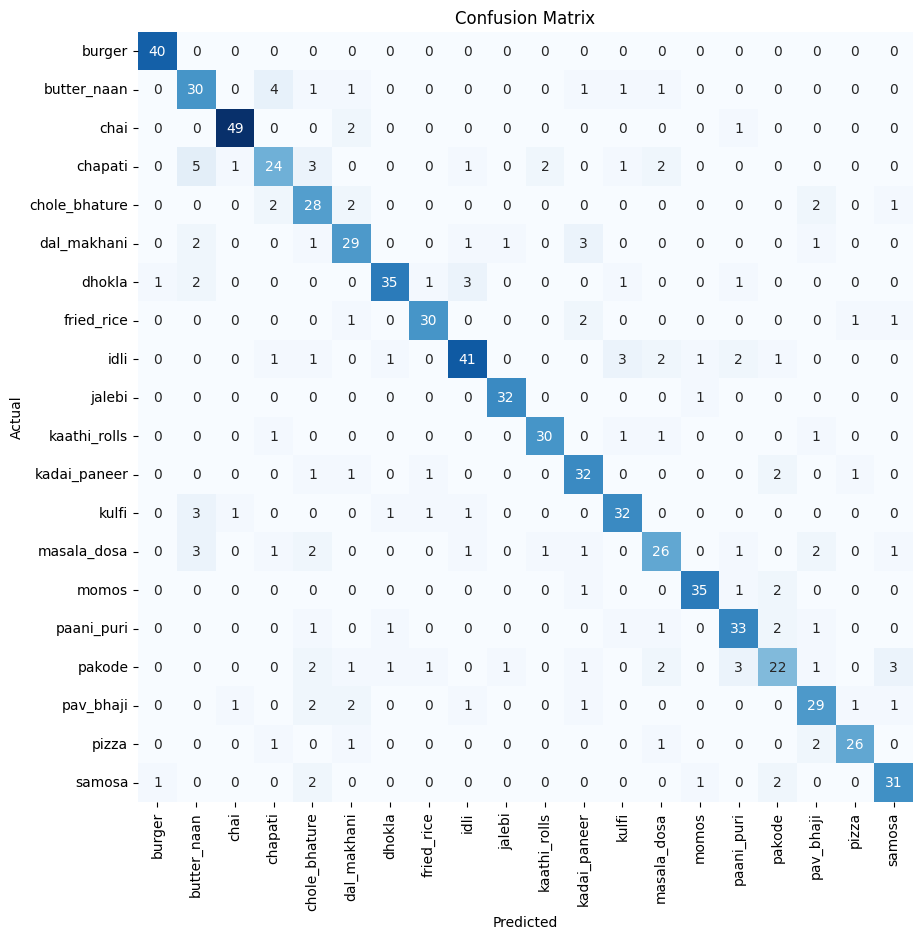

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(20) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(20) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                precision    recall  f1-score   support

       burger       0.95      1.00      0.98        40
  butter_naan       0.67      0.77      0.71        39
         chai       0.94      0.94      0.94        52
      chapati       0.71      0.62      0.66        39
chole_bhature       0.64      0.80      0.71        35
  dal_makhani       0.72      0.76      0.74        38
       dhokla       0.90      0.80      0.84        44
   fried_rice       0.88      0.86      0.87        35
         idli       0.84      0.77      0.80        53
       jalebi       0.94      0.97      0.96        33
 kaathi_rolls       0.91      0.88      0.90        34
 kadai_paneer       0.76      0.84      0.80        38
        kulfi       0.80      0.82      0.81        39
  masala_dosa       0.72      0.67      0.69        39
        momos       0.92      0.90      0.91        39
   paani_puri       0.79      0.82      0.80        40
       pakode    

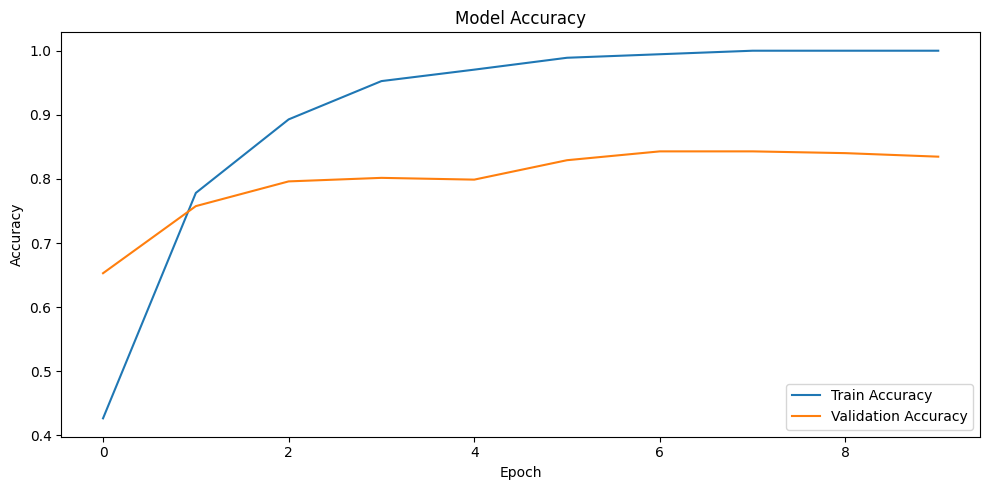

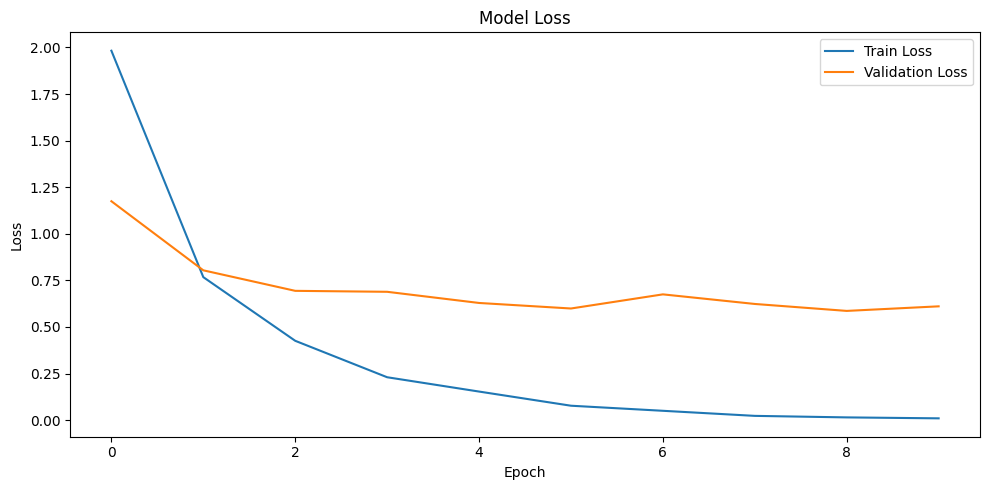

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
if 'fine_tune_history' in locals():  # Check if fine_tune_history exists
    plt.plot(np.arange(len(history.history['accuracy']), len(history.history['accuracy']) + len(fine_tune_history.history['accuracy'])),
             fine_tune_history.history['accuracy'], label='Fine-tune Train Accuracy')
    plt.plot(np.arange(len(history.history['val_accuracy']), len(history.history['val_accuracy']) + len(fine_tune_history.history['val_accuracy'])),
             fine_tune_history.history['val_accuracy'], label='Fine-tune Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
if 'fine_tune_history' in locals():  # Check if fine_tune_history exists
    plt.plot(np.arange(len(history.history['loss']), len(history.history['loss']) + len(fine_tune_history.history['loss'])),
             fine_tune_history.history['loss'], label='Fine-tune Train Loss')
    plt.plot(np.arange(len(history.history['val_loss']), len(history.history['val_loss']) + len(fine_tune_history.history['val_loss'])),
             fine_tune_history.history['val_loss'], label='Fine-tune Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

